# IMAGINE tutorial 3

### hammurabiX + BregWMAP + CREAna

this tutorial presents the interface between IMAGINE and hammurabiX

In [1]:
%matplotlib inline

import unittest
import os
import numpy as np

from imagine.observables.observable_dict import Measurements
from imagine.simulators.hammurabi.hammurabi import Hammurabi
from imagine.fields.breg_wmap.hamx_field import BregWMAP
from imagine.fields.cre_analytic.hamx_field import CREAna
from imagine.fields.fereg_ymw16.hamx_field import FEregYMW16

hammurabiX is interfaced by **Hammurabi** class which wrapped hammurabiX python wrapper **hampyx**

it is convenient not using **hampyx** directly, considering future updates in hammurabiX

we haven't managed to make **hampyx** XML file free, as a consequence, template XML file is still necessary

In [2]:
# empty measuremnts
arr32 = np.zeros((1, 12*32**2))
arr16 = np.zeros((1, 12*16**2))
arr8 = np.zeros((1, 12*8**2))
measuredict = Measurements()
measuredict.append(('sync', '23', '32', 'I'), arr32)  # healpix map
measuredict.append(('fd', 'nan', '16', 'nan'), arr16)
measuredict.append(('dm', 'nan', '8', 'nan'), arr8)
# consider only init, hammurabi executable is not necessary
xmlpath = './template.xml'
simer = Hammurabi(measurements=measuredict,xml_path=xmlpath)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}


without IMAGINE pipeline, we illustrate how hammurabiX is invoked internally

In [3]:
# ensemble size
ensemble_size = 2

# BregWMAP field
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_wmap = BregWMAP(paramlist, ensemble_size)
# CREAna field
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.6, 'z0': 1.2,
             'E0': 20.5,
             'j0': 0.03}
cre_ana = CREAna(paramlist, ensemble_size)
# FEregYMW16 field
paramlist = dict()
fereg_ymw16 = FEregYMW16(paramlist, ensemble_size)

# push fields to simulator
simer.register_fields([breg_wmap, cre_ana, fereg_ymw16])

# check initialization
simer._ham.print_par(['magneticfield', 'regular'])
simer._ham.print_par(['magneticfield', 'regular', 'wmap'])
simer._ham.print_par(['cre'])
simer._ham.print_par(['cre', 'analytic'])
simer._ham.print_par(['freeelectron', 'regular'])

regular {'cue': '1', 'type': 'wmap'}
|-->  wmap {}
|-->  jaffe {}
|-->  unif {}
wmap {}
|-->  b0 {'value': '6.0'}
|-->  psi0 {'value': '27.9'}
|-->  psi1 {'value': '1.3'}
|-->  chi0 {'value': '24.6'}
cre {'cue': '1', 'type': 'analytic'}
|-->  analytic {}
|-->  unif {}
analytic {}
|-->  alpha {'value': '3.0'}
|-->  beta {'value': '0.0'}
|-->  theta {'value': '0.0'}
|-->  r0 {'value': '5.6'}
|-->  z0 {'value': '1.2'}
|-->  E0 {'value': '20.5'}
|-->  j0 {'value': '0.03'}
regular {'cue': '1', 'type': 'ymw16'}
|-->  ymw16 {}
|-->  unif {}


hammurabiX main routine is binded to call method of **Simulator**

In [4]:
maps = simer([breg_wmap, cre_ana, fereg_ymw16])

**Simulator** by convention returns a **Simulations** object, which collect all required maps

dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])
(2, 12288) (2, 768) (2, 3072)
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


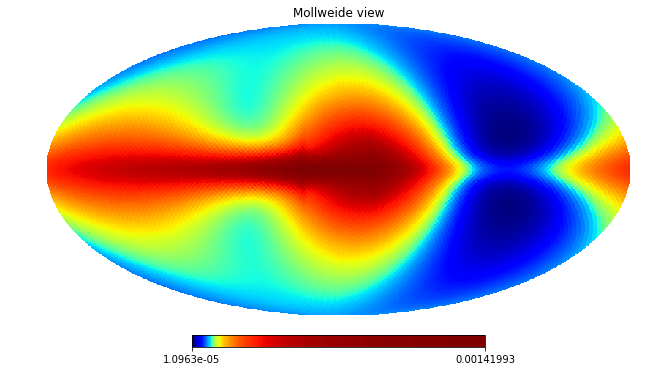

In [5]:
import healpy as hp
from matplotlib import cm

print (maps.keys())

sync_i_raw = maps[('sync','23','32','I')].to_global_data()
dm_raw = maps[('dm', 'nan', '8', 'nan')].to_global_data()
fd_raw = maps[('fd', 'nan', '16', 'nan')].to_global_data()

print (sync_i_raw.shape, dm_raw.shape, fd_raw.shape)

for j in range(dm_raw.shape[1]):
    assert (dm_raw[0,j] == dm_raw[1,j])

hp.write_map('tmp.fits',sync_i_raw)
m = hp.read_map('tmp.fits')
hp.mollview(m,norm='hist',cmap='jet')
os.remove('tmp.fits')

### + BrndES

now we add a random GMF

the FFT box size is defined in hammurabiX XML parameter file

In [6]:
from imagine.fields.brnd_es.hamx_field import BrndES

paramlist = {'rms': 6., 'k0': 0.5, 'a0': 1.7, 'rho': 0.5, 'r0': 8., 'z0': 1.}
brnd_es = BrndES(paramlist, ensemble_size)

In [7]:
maps = simer([breg_wmap, brnd_es, cre_ana, fereg_ymw16])

dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])
(2, 12288) (2, 768) (2, 3072)
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


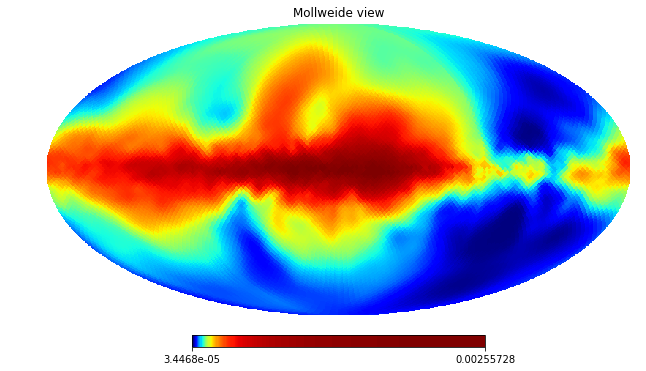

In [8]:
import healpy as hp
from matplotlib import cm

print (maps.keys())

sync_i_raw = maps[('sync','23','32','I')].to_global_data()
dm_raw = maps[('dm', 'nan', '8', 'nan')].to_global_data()
fd_raw = maps[('fd', 'nan', '16', 'nan')].to_global_data()

print (sync_i_raw.shape, dm_raw.shape, fd_raw.shape)

for j in range(dm_raw.shape[1]):
    assert (dm_raw[0,j] == dm_raw[1,j])

hp.write_map('tmp.fits',sync_i_raw)
m = hp.read_map('tmp.fits')
hp.mollview(m,norm='hist',cmap='jet')
os.remove('tmp.fits')